In [21]:
import os
import glob
import json
import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from atek.dataset.adt_wds import get_adt_wds_dataset
from atek.dataset.adt_wds import get_adt_dataloader

from projectaria_tools.projects.adt import (
    bbox2d_to_image_coordinates,
)

from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer

from cubercnn.config import get_cfg_defaults
from cubercnn.modeling.meta_arch import RCNN3D, build_model
from cubercnn.modeling.backbone import build_dla_from_vision_fpn_backbone
from cubercnn.modeling.proposal_generator import RPNWithIgnore
from cubercnn.modeling.roi_heads import ROIHeads3D
from cubercnn import util, vis, data

from detectron2.utils.events import EventStorage

In [2]:
adt_dir = "/source/data/atek/adt_503849115/1WM09380061283_optitrack_release_recognition_BambooPlate_seq030"
id_map_json = "/work_1a/zhengkang/ATEK/data/adt_id_mapping.json"

with open(id_map_json, "r") as f:
    id_map = json.load(f)
    id_map = {int(k): int(v) for k, v in id_map.items()}
    num_classes = max(id_map.values()) + 1

tar_files = glob.glob(adt_dir + "/*.tar")
adt_dataset = get_adt_wds_dataset(tar_files, id_map)
adt_dataloader = get_adt_dataloader(adt_dataset)

dict_keys(['image', 'width', 'height', 'K', 'instances', 'sequence_name', 'frame_id', 'timestamp_ns', '__key__'])


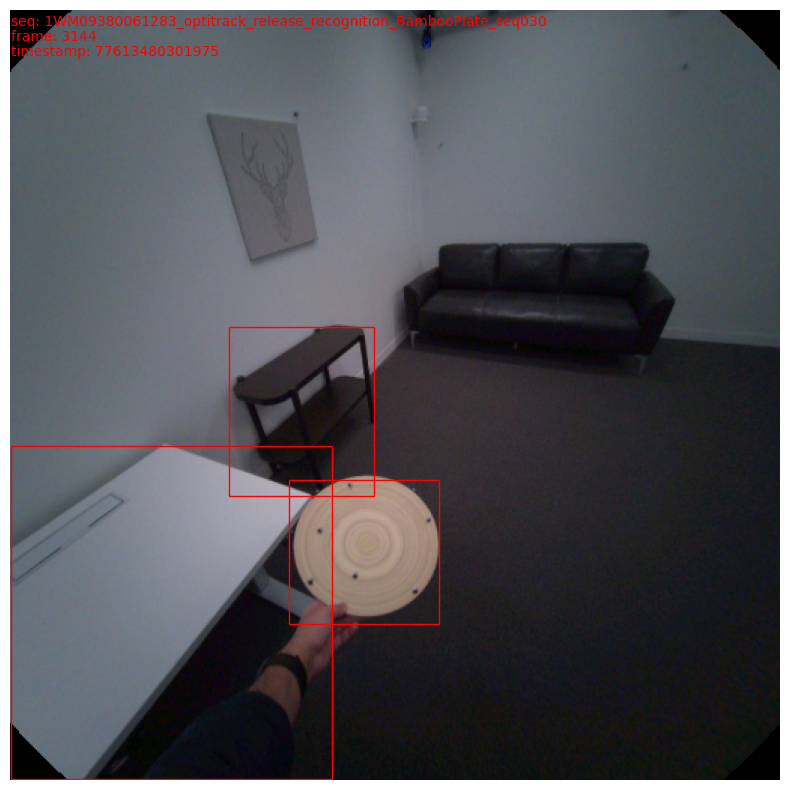

In [4]:
data_iter = iter(adt_dataloader)

data = next(data_iter)
print(data[0].keys())
image_np = data[0]["image"].numpy().transpose(1, 2, 0)[:, :, ::-1]

seq_name = os.path.basename(os.path.dirname(data[0]["sequence_name"]))
frame_id = data[0]["frame_id"]
ts = data[0]["timestamp_ns"]

# fig = plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(image_np)
plt.axis("off")
plt.text(0, 10, f"seq: {seq_name}", color="r")
plt.text(0, 20, f"frame: {frame_id}", color="r")
plt.text(0, 30, f"timestamp: {ts}", color="r")
for bb2d in data[0]["instances"].gt_boxes.tensor.numpy():
    # print(bb2d)
    image_coord = bbox2d_to_image_coordinates(bb2d)
    rect = patches.Polygon(image_coord, closed=True, fill=False, edgecolor='r')
    ax.add_patch(rect)
plt.show()

In [5]:
image_coord

[array([145.42129517, 210.40470886]),
 array([241.30480957, 210.40470886]),
 array([241.30480957, 322.39013672]),
 array([145.42129517, 322.39013672])]

In [6]:
data[0]["instances"]

Instances(num_instances=3, image_height=512, image_width=512, fields=[gt_classes: tensor([349, 356, 122]), gt_boxes: Boxes(tensor([[  0.0000, 213.7467, 289.3625, 511.0000],
        [184.9056, 284.4524, 311.8486, 407.8773],
        [145.4213, 241.3048, 210.4047, 322.3901]])), gt_boxes3D: tensor([[ 1.6095e+01,  5.0473e+02,  8.4229e-01,  7.7704e-01,  6.4778e-01,
          1.5340e+00, -9.1192e-01,  9.4934e-01,  8.4229e-01],
        [ 2.3622e+02,  3.5465e+02,  7.1176e-01,  3.0000e-01,  5.0134e-02,
          3.0000e-01, -6.2044e-02,  3.1914e-01,  7.1176e-01],
        [ 2.0363e+02,  2.6335e+02,  2.0976e+00,  3.7800e-01,  7.0502e-01,
          9.1800e-01, -4.9207e-01,  7.4480e-02,  2.0976e+00]]), gt_poses: tensor([[[ 0.3969, -0.0670,  0.9154],
         [-0.5174, -0.8401,  0.1629],
         [ 0.7581, -0.5383, -0.3681]],

        [[-0.6896,  0.1153, -0.7150],
         [ 0.3759, -0.7869, -0.4894],
         [-0.6191, -0.6062,  0.4993]],

        [[-0.4005, -0.0685, -0.9138],
         [ 0.5135, -0.

In [19]:
cfg = get_cfg()
get_cfg_defaults(cfg)
config_file = "/work_1a/zhengkang/ATEK/atek/configs/base_model.yaml"
cfg.merge_from_file(config_file)

In [20]:
cfg.TRAIN_LIST = "/source/data/atek/adt_503849115/train_tars.yaml"
cfg.freeze()

In [8]:
cfg.defrost()
cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
cfg.freeze()
cfg.MODEL.ROI_HEADS.NUM_CLASSES

405

In [9]:
model = build_model(cfg, priors=None)
# # load previous checkpoint's model weights
# DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
#     cfg.MODEL.WEIGHTS, resume=args.resume
# )

model.train()


RCNN3D(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral6): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bottom_up): DLABackbone(
      (base_layer): Sequential(
        (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (1): BatchNorm2d(16

In [10]:
start_iter = 0
# max_iter = cfg.SOLVER.MAX_ITER
max_iter = 1000

iteration = start_iter
data_iter = iter(adt_dataloader)

with EventStorage(start_iter) as storage:
    # while True:
    for iteration in tqdm.tqdm(range(max_iter)):
        storage.iter = iteration

        data = next(data_iter, None)
        if data is None:
            break

        loss_dict = model(data)

        if iteration > max_iter:
            break


  0%|          | 0/1000 [00:00<?, ?it/s]/data/home/zhengkang/miniconda3/envs/atek_omni3d/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 12%|█▎        | 125/1000 [00:15<01:50,  7.93it/s]
